In [22]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

from joblib import dump, load

In [2]:
df = pd.read_csv("../data/processed/processed_final.csv")

In [3]:
df.head(2)

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,Adjusted_Cost,Profit,Profit_Percentage
0,90,45.0,Urban,Silver,13,4.47,Night,Premium,90,284.257273,270.971017,-13.286256,-4.674025
1,58,39.0,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753,157.709039,-16.165714,-9.297332


## Feature and Target Selection

**Target Variable**

- **Adjusted_Cost:** This directly represents the final cost the user pays for the ride (primary goal).

**Feature Selection**

**Selecting features that might influence dynamic pricing:**

**Demand-Supply Features:**

- **Number_of_Riders:** Higher demand could lead to higher prices.

- **Number_of_Drivers:** Lower driver availability could lead to higher prices.

**Customer and Ride Characteristics:**

**Location_Category (Rural, Suburban, Urban):** Prices might vary based on location.

**Customer_Loyalty_Status (Gold, Regular, Silver):** Loyalty programs might offer discounts.

**Time_of_Booking (Morning, Afternoon, Evening, Night):** Surge pricing during peak hours.

**Vehicle_Type (Economy, Premium):** Premium vehicles might cost more.

**Number_of_Past_Rides:** Frequent riders might get discounts.

**Average_Ratings (Driver or Rider):** Higher ratings might influence pricing (consider for future exploration).

**Customer Loyalty Status:** Loyal customers might receive discounts or price adjustments.

**Expected Ride Duration:** It can influence the pricing based on factors like distance and time.
########################################################################################################################################################################################################

**Target Variable:** "Adjusted_Cost" or "Profit"

**Features:**

- Number_of_Riders
- Number_of_Drivers
- Location_Category_* (all three categories)
- Customer_Loyalty_Status_* (all three categories)
- Time_of_Booking_* (all four categories)
- Vehicle_Type_* (both categories)
- Number_of_Past_Rides
- Customer Loyalty Status
- Expected Ride Duration

In [4]:
# Select features and target variable
features = ['Number_of_Riders',
            'Number_of_Drivers',
            'Location_Category', 
            'Customer_Loyalty_Status',
            'Number_of_Past_Rides',
            'Average_Ratings', 
            'Time_of_Booking',
            'Vehicle_Type',
            'Expected_Ride_Duration'
]
target = 'Adjusted_Cost'

## Split Data

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

## Baseline Model

In [6]:
# Calculate the average adjusted cost
def baseline_model(data):
    return data.mean()

In [7]:
baseline = baseline_model(y_train)
baseline

457.310296869885

In [8]:
baseline_predictions = [baseline] * len(y_test)
baseline_predictions[:10]

[457.310296869885,
 457.310296869885,
 457.310296869885,
 457.310296869885,
 457.310296869885,
 457.310296869885,
 457.310296869885,
 457.310296869885,
 457.310296869885,
 457.310296869885]

In [9]:
mse = mean_squared_error(y_test, baseline_predictions)
r2 = r2_score(y_test, baseline_predictions)

print(f"Mean Squared Error (MSE) of baseline model: {mse}")
print(f"R-squared of baseline model: {r2}")

Mean Squared Error (MSE) of baseline model: 70609.74722367842
R-squared of baseline model: -0.004450854953004901


**Mean Squared Error (MSE) of 70609.75:**

- A high MSE signifies that the average squared difference between the predicted and actual adjusted costs is significant. In simpler terms, the baseline model's predictions are often far from the real values.

**R-squared of -0.0045:**

- It suggests that the baseline model's predictions are no better than simply predicting the average adjusted cost. In other words, the model doesn't explain any of the variance in the adjusted cost data.

# Model Building

In [10]:
# Define preprocessing steps for numerical and categorical features
numeric_features = ['Number_of_Riders', 'Number_of_Drivers', 'Number_of_Past_Rides', 
                    'Average_Ratings', 'Expected_Ride_Duration']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_features = ['Location_Category', 'Customer_Loyalty_Status', 'Time_of_Booking', 'Vehicle_Type']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [11]:
# Combine preprocessing steps for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [12]:
# Define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Number_of_Riders',
                                                   'Number_of_Drivers',
                                                   'Number_of_Past_Rides',
                                                   'Average_Ratings',
                                                   'Expected_Ride_Duration']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Location_Category',
                                                   'Customer_Loyalty_Status',
                                                   'Time_of_Booking',
                                                   'Vehicle_Type'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

## Model Evaluation and Feature Importance

In [13]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared:", r2)

Mean Squared Error (MSE): 8900.106832079251
R-squared: 0.8733925517629212


**Mean Squared Error (MSE): 8887.1066**

- The MSE measures the average squared difference between the actual and predicted values. In this case, the MSE of approximately 8887.1066 indicates the average squared error between the actual adjusted cost and the predicted adjusted cost by the model.

**R-squared (R^2): 0.8736**

- The R-squared value, also known as the coefficient of determination, represents the proportion of variance in the target variable (Adjusted Cost) that is explained by the independent variables (features) in the model. In this case, the R-squared value of approximately 0.8736 indicates that the model explains approximately 87.36% of the variance in the adjusted cost, which suggests a good fit of the model to the data.

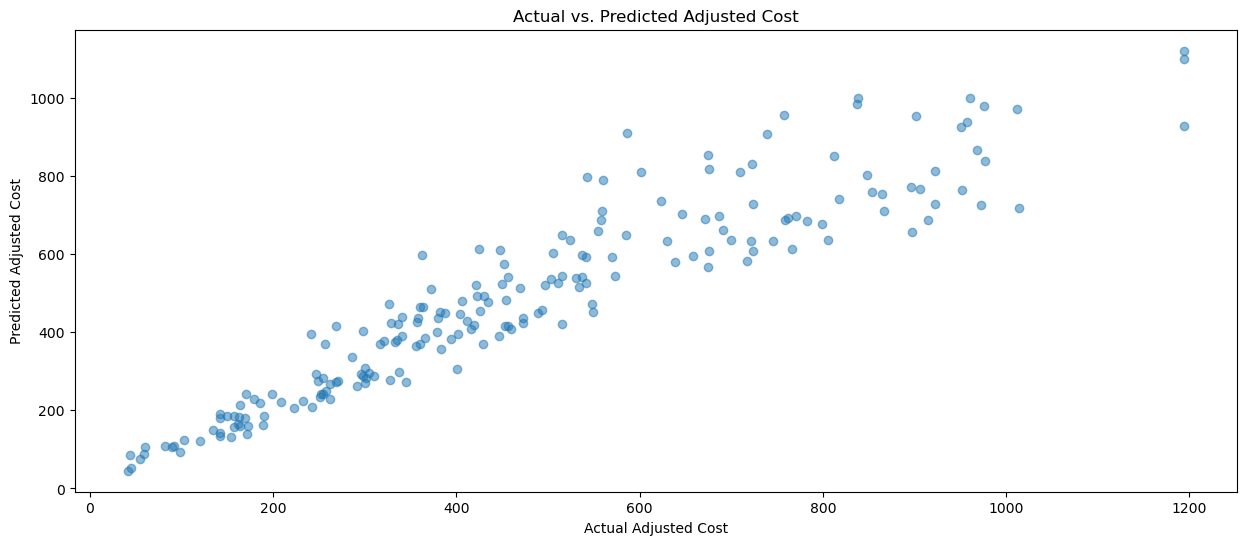

In [14]:
# Actual vs. Predicted Plot
plt.figure(figsize=(15, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Adjusted Cost")
plt.ylabel("Predicted Adjusted Cost")
plt.title("Actual vs. Predicted Adjusted Cost")
plt.show()

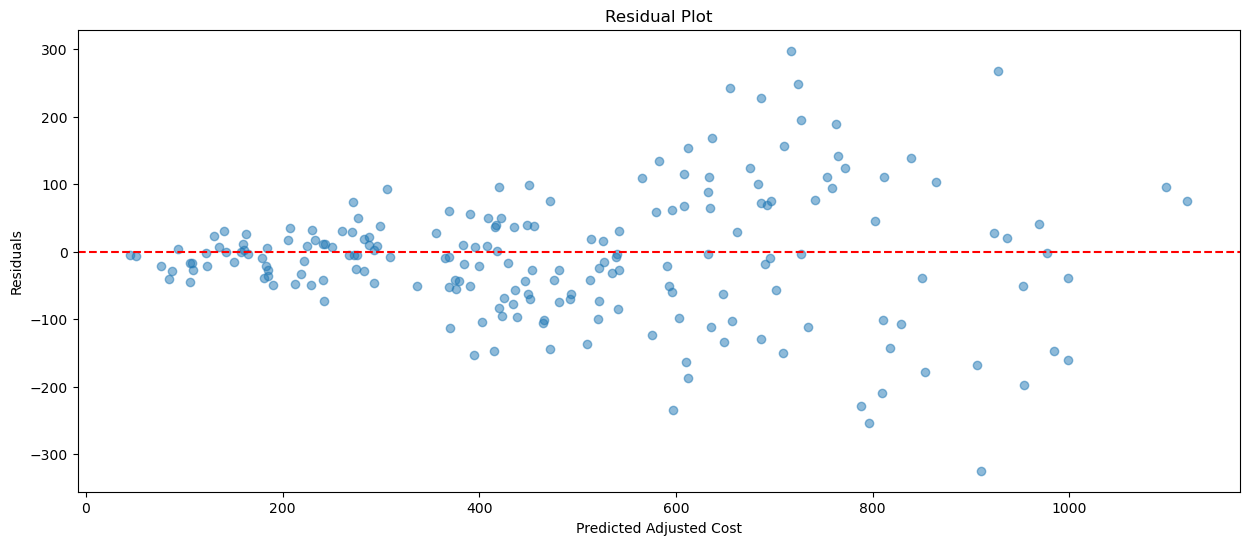

In [15]:
# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(15, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel("Predicted Adjusted Cost")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

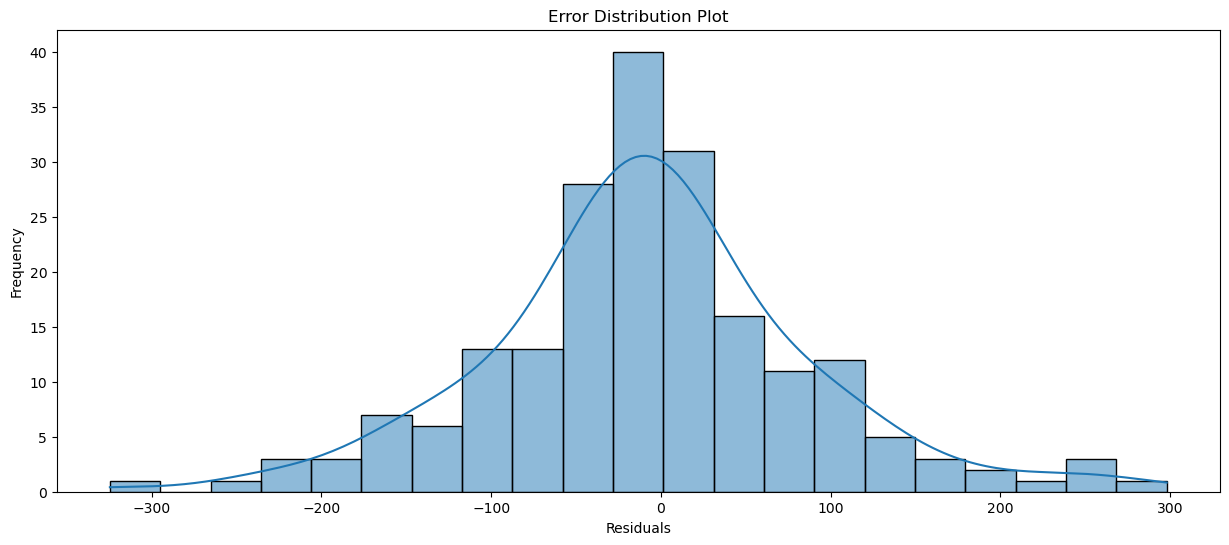

In [16]:
# Error Distribution Plot
plt.figure(figsize=(15, 6))
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Error Distribution Plot")
plt.show()

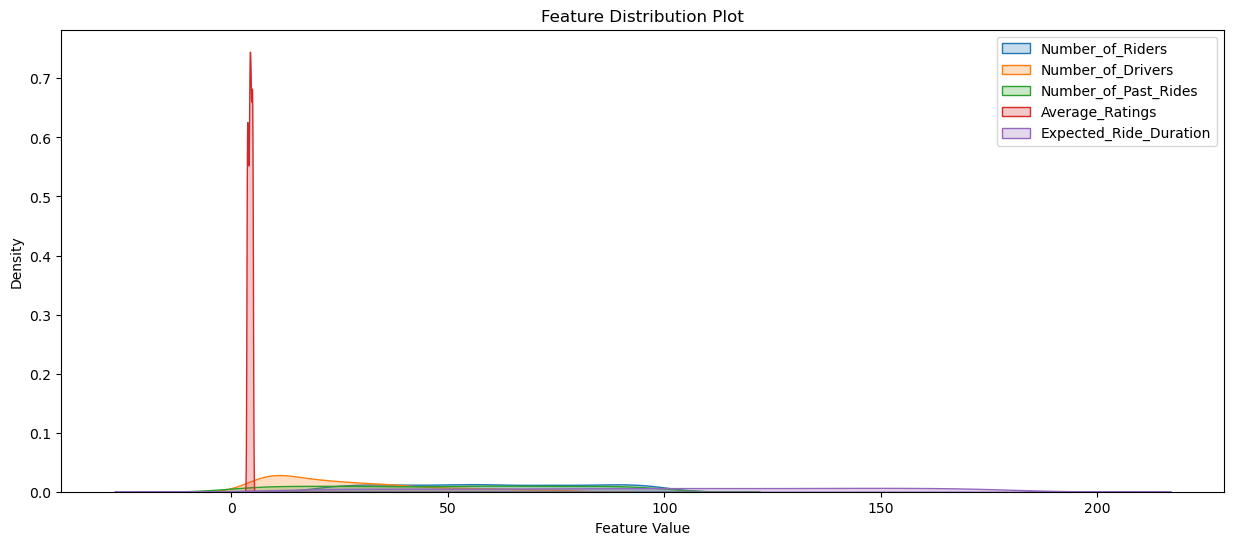

In [17]:
# Feature Distribution Plot
plt.figure(figsize=(15, 6))
for feature in numeric_features:
    sns.kdeplot(df[feature], label=feature, fill=True)
plt.xlabel("Feature Value")
plt.ylabel("Density")
plt.title("Feature Distribution Plot")
plt.legend()
plt.show()

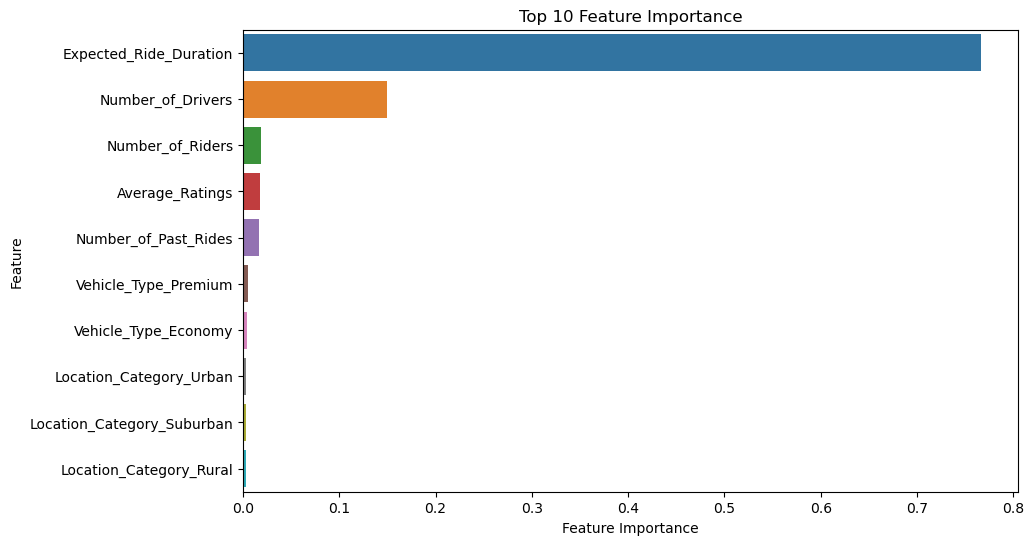

In [18]:
# Feature Importance Plot
feature_importance = model.named_steps['regressor'].feature_importances_
preprocessor = model.named_steps['preprocessor']
feature_names = numeric_features + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(input_features=categorical_features))
sorted_indices = feature_importance.argsort()[::-1][:10]  # Top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance[sorted_indices], y=[feature_names[i] for i in sorted_indices])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importance")
plt.show()

## Save model and make single predictions

In [19]:
# Save the pipeline model
dump(model, '../model/pipeline_model.joblib')

['../model/pipeline_model.joblib']

In [20]:
# Load the saved pipeline model
loaded_pipeline = load('../model/pipeline_model.joblib')

def predict_single(data, pipeline):
    """
    Function to make single predictions using the loaded pipeline model.

    Parameters:
        data (dict or DataFrame): Input data for prediction.
        pipeline (Pipeline): Loaded pipeline model.

    Returns:
        float: Predicted value.
    """
    if isinstance(data, dict):
        data = pd.DataFrame([data])
    return round(pipeline.predict(data)[0], 2)

In [21]:
input_data = {
    'Number_of_Riders': 70,
    'Number_of_Drivers': 50,
    'Location_Category': 'Urban',
    'Customer_Loyalty_Status': 'Silver',
    'Number_of_Past_Rides': 20,
    'Average_Ratings': 4.5,
    'Time_of_Booking': 'Morning',
    'Vehicle_Type': 'Economy',
    'Expected_Ride_Duration': 120,
}

prediction = predict_single(input_data, loaded_pipeline)
print("Predicted Adjusted Cost:", prediction)

Predicted Adjusted Cost: 393.94


## Hyperparameter Tuning

In [23]:
# Define the hyperparameters grid for Grid Search
param_grid = {
    'regressor__n_estimators': [50, 100, 150],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5, 10]
}

In [24]:
# Define the model
model2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [25]:
# Perform Grid Search Cross-Validation
grid_search = GridSearchCV(model2, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'regressor__max_depth': None, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 100}


In [26]:
# Train a new model with the best hyperparameters
best_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(max_depth=None, min_samples_split=10, n_estimators=100, random_state=42))
])

# Fit the new model
best_model.fit(X_train, y_train)

# Make predictions
y_pred_best = best_model.predict(X_test)

# Evaluate the new model
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("Mean Squared Error (MSE) with best model:", mse_best)
print("R-squared with best model:", r2_best)

Mean Squared Error (MSE) with best model: 8862.173175676515
R-squared with best model: 0.8739321726382732


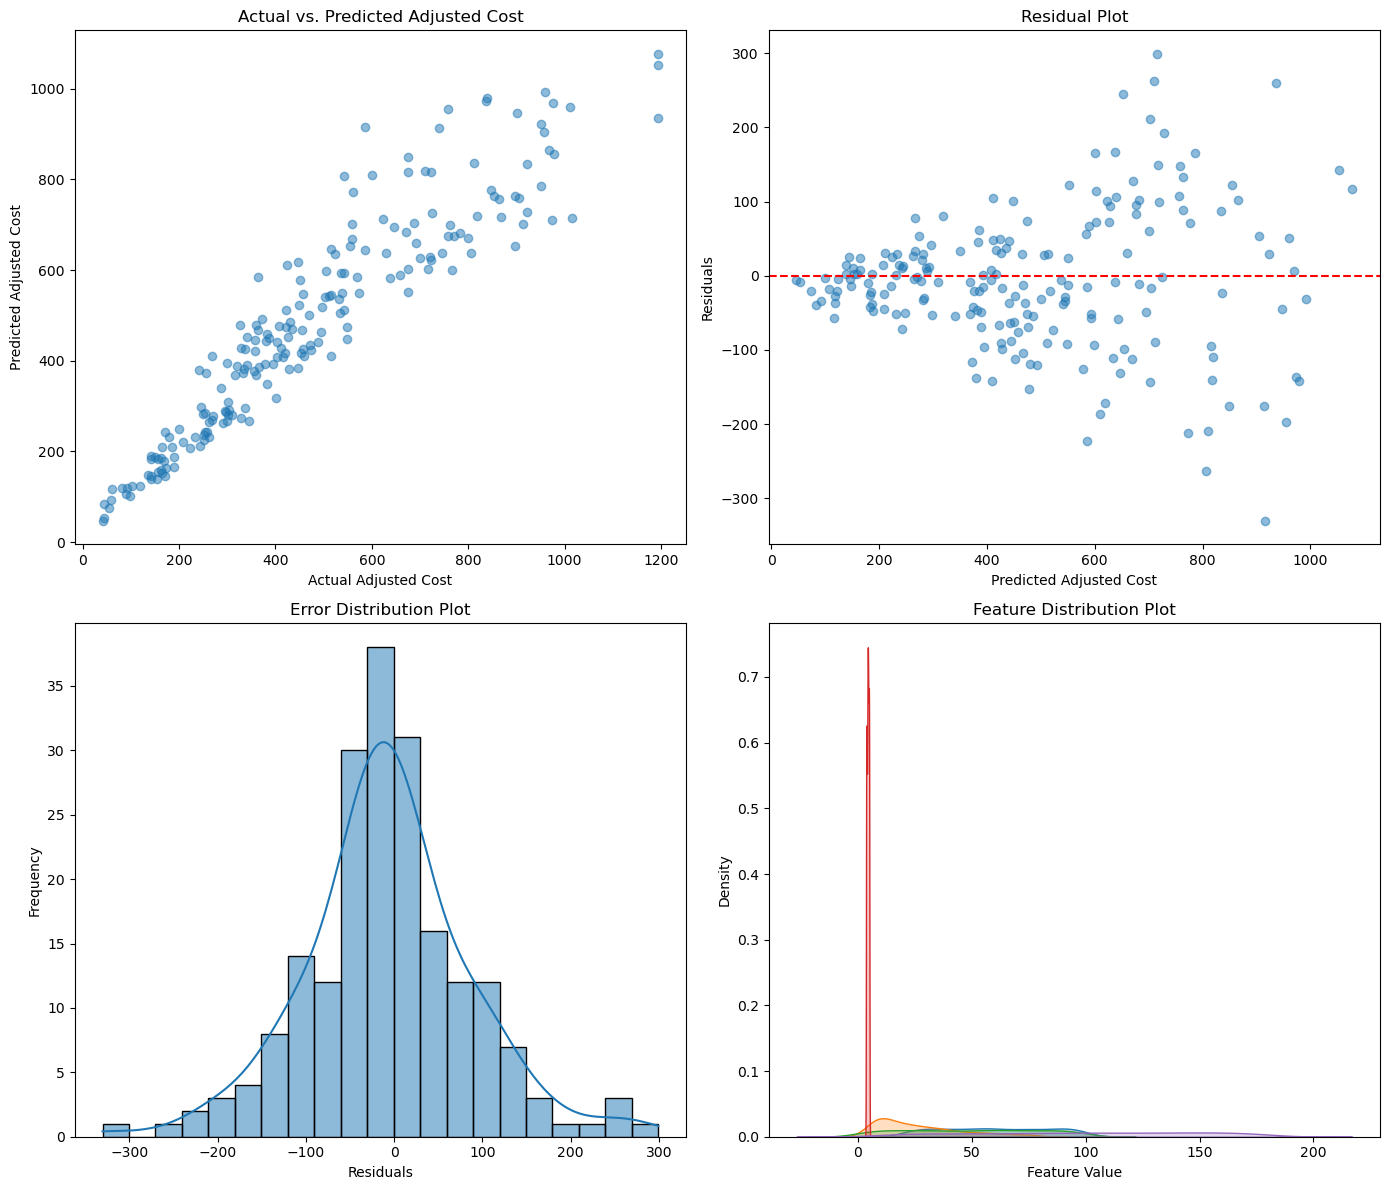

In [27]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Actual vs. Predicted Plot
axes[0, 0].scatter(y_test, y_pred_best, alpha=0.5)
axes[0, 0].set_xlabel("Actual Adjusted Cost")
axes[0, 0].set_ylabel("Predicted Adjusted Cost")
axes[0, 0].set_title("Actual vs. Predicted Adjusted Cost")

# Residual Plot
residuals = y_test - y_pred_best
axes[0, 1].scatter(y_pred_best, residuals, alpha=0.5)
axes[0, 1].set_xlabel("Predicted Adjusted Cost")
axes[0, 1].set_ylabel("Residuals")
axes[0, 1].set_title("Residual Plot")
axes[0, 1].axhline(y=0, color='r', linestyle='--')

# Error Distribution Plot
sns.histplot(residuals, kde=True, ax=axes[1, 0])
axes[1, 0].set_xlabel("Residuals")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].set_title("Error Distribution Plot")

# Feature Distribution Plot
for i, feature in enumerate(numeric_features):
    sns.kdeplot(df[feature], label=feature, fill=True, ax=axes[1, 1])
axes[1, 1].set_xlabel("Feature Value")
axes[1, 1].set_ylabel("Density")
axes[1, 1].set_title("Feature Distribution Plot")

# Adjust layout
plt.tight_layout()
plt.show()

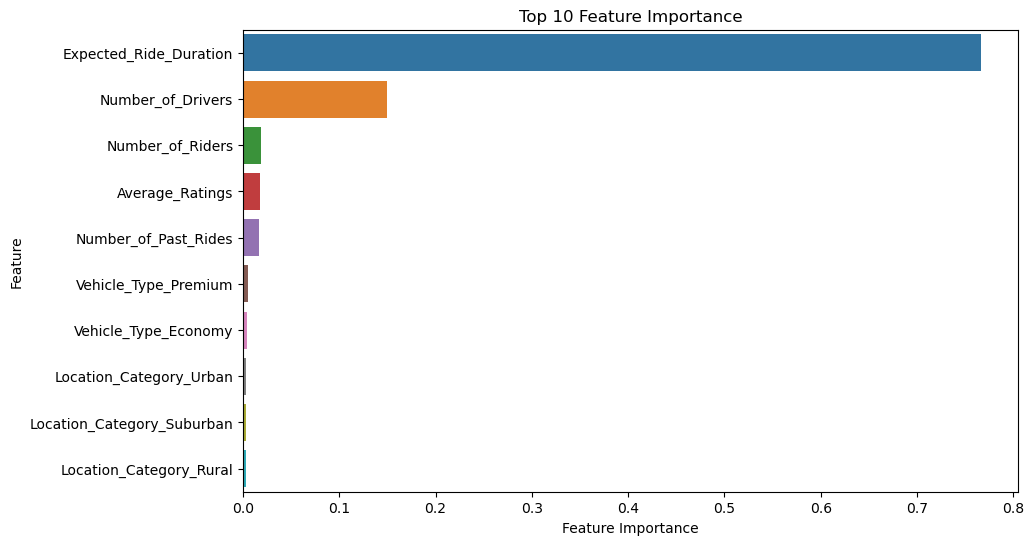

In [28]:
# Feature Importance Plot
feature_importance = model.named_steps['regressor'].feature_importances_
preprocessor = best_model.named_steps['preprocessor']
feature_names = numeric_features + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(input_features=categorical_features))
sorted_indices = feature_importance.argsort()[::-1][:10]  # Top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance[sorted_indices], y=[feature_names[i] for i in sorted_indices])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importance")
plt.show()

In [29]:
# Save the best pipeline model
dump(model, '../models/best_model.joblib')

['../models/best_model.joblib']

In [31]:
# Load the saved pipeline model
best_model = load('../models/best_model.joblib')

def predict_single(data, pipeline):
    """
    Function to make single predictions using the loaded pipeline model.

    Parameters:
        data (dict or DataFrame): Input data for prediction.
        pipeline (Pipeline): Loaded pipeline model.

    Returns:
        float: Predicted value.
    """
    if isinstance(data, dict):
        data = pd.DataFrame([data])
    return round(pipeline.predict(data)[0], 2)


input_data = {
    'Number_of_Riders': 70,
    'Number_of_Drivers': 50,
    'Location_Category': 'Urban',
    'Customer_Loyalty_Status': 'Silver',
    'Number_of_Past_Rides': 20,
    'Average_Ratings': 4.5,
    'Time_of_Booking': 'Morning',
    'Vehicle_Type': 'Economy',
    'Expected_Ride_Duration': 120,
    'Historical_Cost_of_Ride': 300
}

prediction = predict_single(input_data, best_model)
print("Predicted Adjusted Cost:", prediction)

Predicted Adjusted Cost: 393.94
